# Natural Language Processing with Deep Learning (7 points)

Today we're gonna apply the newly learned DL tools for sequence processing to the task of predicting job salary.

Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the assignment core (orignally written for theano/tensorflow).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from collections import Counter
from sklearn.feature_extraction import DictVectorizer
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

%matplotlib inline

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

Using device: cuda



### About the challenge
For starters, let's download the data from __[here](https://yadi.sk/d/vVEOWPFY3NruT7)__.

You can also get it from the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (in that case, pick `Train_rev1.*`).


Our task is to predict one number, __SalaryNormalized__, in the sense of minimizing __Mean Absolute Error__.

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png" width=400px>

To do so, our model can access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.


You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description).

In [3]:
data = pd.read_csv("./Train_rev1.csv", index_col=None)
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"
data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast nan to string

data.sample(3)['FullDescription']

103927    Day Care Assistant Older People (Denbigshire) ...
15152     Hafod Care Association are currently looking f...
34843     Banking and Finance Legal Secretary Watford, H...
Name: FullDescription, dtype: object

In [4]:
data.sample(3)

Id                                         Title  \
6520    63722012  Maintenance Electrical Technician (Beverage)   
61117   68695290                        Data Migration Analyst   
194680  71795893                    IT SALES – ACCOUNT MANAGER   

                                          FullDescription  \
6520    We are looking for a Maintenance Electrical Te...   
61117   Ambitious Graduates with good IT skills and ex...   
194680  IT SALES ACCOUNT MANAGERUK WIDEERP FINANCIAL /...   

                                              LocationRaw LocationNormalized  \
6520    Bradford, Halifax, Huddersfield, Leeds, Pontef...                 UK   
61117                                   London South East  South East London   
194680                                      East Midlands      East Midlands   

       ContractType ContractTime                   Company          Category  \
6520            NaN    permanent  Questech Recruitment Ltd  Engineering Jobs   
61117           NaN     contract                SRS BUREAU           IT Jobs   
194680          NaN    permanent                       NaN        Sales Jobs   

                                        SalaryRaw  SalaryNormalized  \
6520             40000/annum 40,000 plus benefits             40000   
61117   Up to 21,000 per annum Benefits and Bonus             21000   
194680                                  40k - 50k             45000   

                   SourceName  Log1pSalary  
6520         cv-library.co.uk    10.596660  
61117           totaljobs.com     9.952325  
194680  simplysalesjobs.co.uk    10.714440

### The NLP part

To even begin training our neural network, we're gonna need to preprocess the text features: tokenize it and build the token vocabularies.

Since it is not an NLP course, we're gonna use simple built-in NLTK tokenization.

In [5]:
print("Before")
print(data["Title"][::100000])

Before
0         Engineering Systems Analyst
100000                   HR Assistant
200000           Senior EC&I Engineer
Name: Title, dtype: object


In [6]:
tokenizer = nltk.tokenize.WordPunctTokenizer()

for col in text_columns:
    data[col] = data[col].apply(lambda l: ' '.join(tokenizer.tokenize(str(l).lower())))

Now we can assume that our text is a space-separated list of tokens:

In [7]:
print("After")
print(data["Title"][::100000])

After
0         engineering systems analyst
100000                   hr assistant
200000         senior ec & i engineer
Name: Title, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's see how many times is each word present in the data so that we can build a "white list" of known words.

In [8]:
accumulator = []

# Count how many times does each token occur in "Title" and "FullDescription"
for col in text_columns:
    data[col].apply(lambda l: accumulator.extend((l.split())))

token_counts = Counter(accumulator)

In [9]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


Text(0.5, 0, 'Counts')

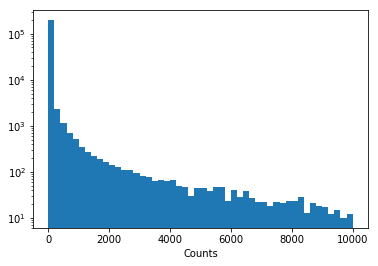

In [10]:
# Let's see how many words are there for each count

_ = plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Counts")

__Task 1.1__ Get a list of all tokens that occur at least 10 times.

In [11]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = [x[0] for x in token_counts.items() if x[1] >= min_count]

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [12]:
print("Tokens left:", len(tokens))
assert type(tokens)==list
assert len(tokens) in range(32000,35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Tokens left: 34158
Correct!


__Task 1.2__ Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [13]:
token_to_id = dict(zip(tokens, range(len(tokens))))

In [14]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into torch-digestible matrices.

In [15]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
    
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [16]:
print("## Lines:\n")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("## Matrix:\n")
print(as_matrix(data["Title"][::100000]))

## Lines:

engineering systems analyst
hr assistant
senior ec & i engineer

## Matrix:

[[   2    3    4    1    1]
 [ 998  176    1    1    1]
 [  18 3472  242   59    6]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement tf-idf, target averaging or pseudo-counter-based encoding.

In [17]:
# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, separator='=', sort=True,
        sparse=False)

### The data science part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [18]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.1, random_state=42)

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  220291
Validation size =  24477


In [19]:
def generate_batch(data, batch_size=None, replace=True, max_len=None):
    """
    Creates a pytorch-friendly dict from the batch data.
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    if batch_size is not None:
        data = data.sample(batch_size, replace=replace)
    
    batch = {}
    for col in text_columns:
        batch[col] = as_matrix(data[col].values, max_len)
    
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if target_column in data.columns:
        batch[target_column] = data[target_column].values
    
    return batch

In [20]:
generate_batch(data_train, 3, max_len=10)

{'Title': array([[ 355,  176,    1,    1,    1],
        [ 263,    9,  286,  622,    1],
        [ 303, 2316, 1856, 2505, 2063]], dtype=int32),
 'FullDescription': array([[3162,  587,  706, 1314, 1464,  944,   73, 2497,  813, 1349],
        [ 561,   92, 2628, 4545, 1464,  560,   86, 2454, 2497,  263],
        [ 142, 1617, 1166,  110, 6357, 1240,    9, 1856,  303,  282]],
       dtype=int32),
 'Categorical': array([[0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'Log1pSalary': array([ 9.757363, 10.523311, 10.308986], dtype=float32)}

### Finally, let's talk deep learning

Out model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/Practical_DL/raw/master/homework04/conv_salary_architecture.png)

By default, both text vectorizers shall use 1d convolutions, followed by global pooling over time.

In [21]:
class GlobalMaxPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
        
    def forward(self, x):
        return x.max(dim=self.dim)[0]

In [22]:
class TitleEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling()        
        self.dense = nn.Linear(out_size, out_size)
        self.activ = nn.ReLU()

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)
        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        h = self.conv1(h)
        h = self.activ(self.pool1(h))
        
        return self.dense(h)

In [23]:
title_encoder = TitleEncoder(out_size=64)

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['Title']))
dummy_v = title_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)

del title_encoder
print("Seems fine")

Seems fine


__Task 2.1__ Create description encoder

In [24]:
# Define an encoder for job descriptions.
# Use any means you want as long as it's torch.nn.Module.
class DescriptionEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for descriptions.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling()        
        self.dense = nn.Linear(out_size, out_size)
        self.activ = nn.ReLU()

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)
        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        h = self.conv1(h)
        h = self.activ(self.pool1(h))
        
        return self.dense(h)

In [25]:
desc_encoder = DescriptionEncoder(out_size=64)

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['FullDescription']))
dummy_v = desc_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)
del desc_encoder
print("Seems fine too")

Seems fine too


__Task 2.2__ Build one network ~~to rule them all~~

In [35]:
class FullNetwork(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """
    
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()
        
        self.title_encoder = TitleEncoder(out_size=64)
        self.desc_encoder = DescriptionEncoder(out_size=64)
        
        # define layers for categorical features. A few dense layers would do.
        self.cat_encoder = nn.Sequential(
            nn.Linear(n_cat_features, 2000),
            nn.ReLU(),
            nn.Linear(2000, 1000),
            nn.ReLU(),
            nn.Linear(1000, 100),
            nn.ReLU()
        )
        
        # define "output" layers that process depend the three encoded vectors into answer
        self.sink = nn.Sequential(
            nn.Linear(100 + 64 + 64, 100),
            nn.ReLU(),
            nn.Linear(100, 1)
        )        
        
    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """
        
        # process each data source with it's respective encoder
        title_h = self.title_encoder(title_ix)
        desc_h = self.desc_encoder(desc_ix)
        
        # apply categorical encoder
        cat_h = self.cat_encoder(cat_features)
        
        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        
        # ... and stack a few more layers at the top
        salary = torch.log1p(self.sink(joint_h))
        
        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.
        
        return salary[:, 0]

In [43]:
model = FullNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [44]:
# test it on one batch

batch = generate_batch(data_train, 32)

title_ix = torch.tensor(batch["Title"], dtype=torch.int64)
desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64)
cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32)
reference = torch.tensor(batch[target_column], dtype=torch.float32)

prediction = model(title_ix.to(device), desc_ix.to(device), cat_features.to(device))

assert len(prediction.shape) == 1 and prediction.shape[0] == title_ix.shape[0]

In [26]:
def compute_loss(reference, prediction):
    """
    Computes objective for minimization.
    By deafult we minimize MSE, but you are encouraged to try mix up MSE, MAE, huber loss, etc.
    """
    return torch.mean((prediction - reference) ** 2)

def compute_mae(reference, prediction):
    """ Compute MAE on actual salary, assuming your model outputs log1p(salary)"""
    return torch.abs(torch.exp(reference) - torch.exp(prediction)).mean()

In [39]:
loss = compute_loss(reference.to(device), prediction)
dummy_grads = torch.autograd.grad(loss, model.parameters(), retain_graph=True)
for grad in dummy_grads:
    assert grad is not None and not (grad == 0).all(), "Some model parameters received zero grads. " \
                                                       "Double-check that your model uses all it's layers."

### Let's train it!

In [27]:
from tqdm import tnrange
def iterate_minibatches(data, batch_size=32, max_len=None,
                        max_batches=None, shuffle=True, verbose=True):
    indices = np.arange(len(data))
    if shuffle:
        indices = np.random.permutation(indices)
    if max_batches is not None:
        indices = indices[: batch_size * max_batches]
        
    irange = tnrange if verbose else range
    
    for start in irange(0, len(indices), batch_size):
        yield generate_batch(data.iloc[indices[start : start + batch_size]], max_len=max_len)

In [41]:
num_epochs = 100
max_len = 100
batch_size = 32
batches_per_epoch = 100

In [57]:
for epoch_i in range(num_epochs):
    print("### Epoch:", epoch_i)
    print("Training:")
    train_loss = train_mae = train_batches = 0    
    model.train(True)
    
    for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch):
        title_ix = torch.tensor(batch["Title"], dtype=torch.int64)
        desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64)
        cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32)
        reference = torch.tensor(batch[target_column], dtype=torch.float32)

        prediction = model(title_ix.to(device), desc_ix.to(device), cat_features.to(device))

        loss = compute_loss(reference.to(device), prediction)
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss += loss.data.cpu().numpy()
        train_mae += compute_mae(reference.to(device), prediction).data.cpu().numpy()
        train_batches += 1
    
    print("\tLoss:\t%.5f" % (train_loss / train_batches))
    print("\tMAE:\t%.5f" % (train_mae / train_batches))
    print('\n\n')
    
    if (epoch_i % 5):
        continue
        
    print("Validation:")
    val_loss = val_mae = val_batches = 0
    model.train(False)
    
    for batch in iterate_minibatches(data_val, shuffle=False):
        title_ix = torch.tensor(batch["Title"], dtype=torch.int64)
        desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64)
        cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32)
        reference = torch.tensor(batch[target_column], dtype=torch.float32)
        prediction = model(title_ix.to(device), desc_ix.to(device), cat_features.to(device))
        loss = compute_loss(reference.to(device), prediction)

        val_loss += loss.data.cpu().numpy()
        val_mae += compute_mae(reference.to(device), prediction).data.cpu().numpy()
        val_batches += 1
        
    print("\tLoss:\t%.5f" % (val_loss / val_batches))
    print("\tMAE:\t%.5f" % (val_mae / val_batches))
    print('\n\n')

### Epoch: 0
Training:



	Loss:	20.67421
	MAE:	30355.95885



Validation:



	Loss:	1.15675
	MAE:	22501.55713



### Epoch: 1
Training:



	Loss:	0.46121
	MAE:	15950.18549



### Epoch: 2
Training:



	Loss:	0.22355
	MAE:	12507.90365



### Epoch: 3
Training:



	Loss:	0.20419
	MAE:	12089.67426



### Epoch: 4
Training:



	Loss:	0.21573
	MAE:	12459.95254



### Epoch: 5
Training:



	Loss:	0.20022
	MAE:	12014.13390



Validation:



	Loss:	0.18970
	MAE:	11567.56715



### Epoch: 6
Training:



	Loss:	0.19348
	MAE:	11612.90449



### Epoch: 7
Training:



	Loss:	0.18575
	MAE:	11592.05104



### Epoch: 8
Training:



	Loss:	0.18206
	MAE:	11368.84221



### Epoch: 9
Training:



	Loss:	0.16941
	MAE:	10935.44923



### Epoch: 10
Training:



	Loss:	0.16498
	MAE:	10620.30104



Validation:



	Loss:	0.16713
	MAE:	10836.76368



### Epoch: 11
Training:



	Loss:	0.15899
	MAE:	10454.15475



### Epoch: 12
Training:



	Loss:	0.16622
	MAE:	10867.08644



### Epoch: 13
Training:



	Loss:	0.17365
	MAE:	10692.02309



### Epoch: 14
Training:



	Loss:	0.16422
	MAE:	10714.32748



### Epoch: 15
Training:



	Loss:	0.15362
	MAE:	10508.76231



Validation:



	Loss:	0.15957
	MAE:	10572.44644



### Epoch: 16
Training:



	Loss:	0.15985
	MAE:	10495.47434



### Epoch: 17
Training:



	Loss:	0.16027
	MAE:	10305.68289



### Epoch: 18
Training:



	Loss:	0.15417
	MAE:	10493.91877



### Epoch: 19
Training:



	Loss:	0.15537
	MAE:	10265.54329



### Epoch: 20
Training:



	Loss:	0.16502
	MAE:	10582.36301



Validation:



	Loss:	0.15586
	MAE:	10458.84747



### Epoch: 21
Training:



	Loss:	0.15589
	MAE:	10622.51727



### Epoch: 22
Training:



	Loss:	0.15888
	MAE:	10342.05252



### Epoch: 23
Training:



	Loss:	0.15515
	MAE:	10420.26645



### Epoch: 24
Training:



	Loss:	0.15015
	MAE:	10387.97280



### Epoch: 25
Training:



	Loss:	0.14986
	MAE:	10244.81433



Validation:



	Loss:	0.15502
	MAE:	10422.09169



### Epoch: 26
Training:



	Loss:	0.15601
	MAE:	10449.59095



### Epoch: 27
Training:



	Loss:	0.15816
	MAE:	10368.02998



### Epoch: 28
Training:



	Loss:	0.15581
	MAE:	10364.00846



### Epoch: 29
Training:



	Loss:	0.15359
	MAE:	10598.19299



### Epoch: 30
Training:



	Loss:	0.15896
	MAE:	10505.99391



Validation:



	Loss:	0.15315
	MAE:	10339.96565



### Epoch: 31
Training:



	Loss:	0.15806
	MAE:	10596.40973



### Epoch: 32
Training:



	Loss:	0.15346
	MAE:	10467.87348



### Epoch: 33
Training:



	Loss:	0.15436
	MAE:	10264.78047



### Epoch: 34
Training:



	Loss:	0.14993
	MAE:	10179.22989



### Epoch: 35
Training:



	Loss:	0.15660
	MAE:	10271.80323



Validation:



	Loss:	0.15205
	MAE:	10312.04437



### Epoch: 36
Training:



	Loss:	0.15601
	MAE:	10388.48873



### Epoch: 37
Training:



	Loss:	0.15406
	MAE:	10314.45280



### Epoch: 38
Training:



	Loss:	0.15617
	MAE:	10191.92401



### Epoch: 39
Training:



	Loss:	0.15126
	MAE:	10254.75307



### Epoch: 40
Training:



	Loss:	0.16043
	MAE:	10639.79998



Validation:



	Loss:	0.15075
	MAE:	10253.43335



### Epoch: 41
Training:



	Loss:	0.15485
	MAE:	10407.93495



### Epoch: 42
Training:



	Loss:	0.14662
	MAE:	9952.12824



### Epoch: 43
Training:



	Loss:	0.15388
	MAE:	10534.50915



### Epoch: 44
Training:



	Loss:	0.14923
	MAE:	10114.95768



### Epoch: 45
Training:



	Loss:	0.15883
	MAE:	10449.92774



Validation:



	Loss:	0.15053
	MAE:	10251.64155



### Epoch: 46
Training:



	Loss:	0.14785
	MAE:	10272.62486



### Epoch: 47
Training:



	Loss:	0.16008
	MAE:	10583.60198



### Epoch: 48
Training:



	Loss:	0.15321
	MAE:	10501.78138



### Epoch: 49
Training:



	Loss:	0.14486
	MAE:	10088.78574



### Epoch: 50
Training:



	Loss:	0.15675
	MAE:	10385.18866



Validation:



	Loss:	0.15096
	MAE:	10263.23191



### Epoch: 51
Training:



	Loss:	0.15010
	MAE:	10316.22422



### Epoch: 52
Training:



	Loss:	0.14733
	MAE:	9977.52029



### Epoch: 53
Training:



	Loss:	0.14861
	MAE:	10280.97282



### Epoch: 54
Training:



	Loss:	0.15282
	MAE:	10351.92164



### Epoch: 55
Training:



	Loss:	0.16145
	MAE:	10542.94460



Validation:



	Loss:	0.14836
	MAE:	10155.06749



### Epoch: 56
Training:



	Loss:	0.14415
	MAE:	10022.76662



### Epoch: 57
Training:



	Loss:	0.14079
	MAE:	9836.55046



### Epoch: 58
Training:



	Loss:	0.14602
	MAE:	9925.55393



### Epoch: 59
Training:



	Loss:	0.14144
	MAE:	9879.15204



### Epoch: 60
Training:



	Loss:	0.14233
	MAE:	10055.70058



Validation:



	Loss:	0.13795
	MAE:	9794.17552



### Epoch: 61
Training:



	Loss:	0.13795
	MAE:	9742.76216



### Epoch: 62
Training:



	Loss:	0.13108
	MAE:	9607.79725



### Epoch: 63
Training:



	Loss:	0.12033
	MAE:	9000.86448



### Epoch: 64
Training:



	Loss:	0.11658
	MAE:	9283.88949



### Epoch: 65
Training:



	Loss:	0.11358
	MAE:	8669.37589



Validation:



	Loss:	0.10831
	MAE:	8612.34489



### Epoch: 66
Training:



	Loss:	0.10675
	MAE:	8649.97224



### Epoch: 67
Training:



	Loss:	0.10096
	MAE:	8286.27194



### Epoch: 68
Training:



	Loss:	0.09790
	MAE:	8233.29071



### Epoch: 69
Training:



	Loss:	0.10279
	MAE:	8539.06373



### Epoch: 70
Training:



	Loss:	0.10367
	MAE:	8269.11343



Validation:



	Loss:	0.09907
	MAE:	8160.45288



### Epoch: 71
Training:



	Loss:	0.09525
	MAE:	7989.36719



### Epoch: 72
Training:



	Loss:	0.09806
	MAE:	8329.61480



### Epoch: 73
Training:



	Loss:	0.09306
	MAE:	7897.17264



### Epoch: 74
Training:



	Loss:	0.09929
	MAE:	8346.58626



### Epoch: 75
Training:



	Loss:	0.10526
	MAE:	8158.05365



Validation:



	Loss:	0.09720
	MAE:	8067.86911



### Epoch: 76
Training:



	Loss:	0.09298
	MAE:	7777.28175



### Epoch: 77
Training:



	Loss:	0.08987
	MAE:	7785.94641



### Epoch: 78
Training:



	Loss:	0.08784
	MAE:	7821.27385



### Epoch: 79
Training:



	Loss:	0.09041
	MAE:	7792.37957



### Epoch: 80
Training:



	Loss:	0.09137
	MAE:	7716.37400



Validation:



	Loss:	0.09159
	MAE:	7803.95947



### Epoch: 81
Training:



	Loss:	0.09408
	MAE:	8137.03679



### Epoch: 82
Training:



	Loss:	0.08915
	MAE:	7711.91524



### Epoch: 83
Training:



	Loss:	0.08971
	MAE:	7759.93189



### Epoch: 84
Training:



	Loss:	0.08765
	MAE:	7732.89469



### Epoch: 85
Training:



	Loss:	0.08569
	MAE:	7654.96437



Validation:



	Loss:	0.08952
	MAE:	7694.14597



### Epoch: 86
Training:



	Loss:	0.08535
	MAE:	7365.70431



### Epoch: 87
Training:



	Loss:	0.09194
	MAE:	7585.23038



### Epoch: 88
Training:



	Loss:	0.08908
	MAE:	7733.87302



### Epoch: 89
Training:



	Loss:	0.08509
	MAE:	7461.58949



### Epoch: 90
Training:



	Loss:	0.08447
	MAE:	7564.01570



Validation:



	Loss:	0.08785
	MAE:	7621.41292



### Epoch: 91
Training:



	Loss:	0.08551
	MAE:	7520.44363



### Epoch: 92
Training:



	Loss:	0.08666
	MAE:	7711.32382



### Epoch: 93
Training:



	Loss:	0.09127
	MAE:	7674.43166



### Epoch: 94
Training:



	Loss:	0.08467
	MAE:	7449.01749



### Epoch: 95
Training:



	Loss:	0.08061
	MAE:	7134.56711



Validation:



	Loss:	0.08534
	MAE:	7540.07822



### Epoch: 96
Training:



	Loss:	0.08211
	MAE:	7327.99332



### Epoch: 97
Training:



	Loss:	0.08630
	MAE:	7753.98983



### Epoch: 98
Training:



	Loss:	0.09138
	MAE:	7604.48055



### Epoch: 99
Training:



	Loss:	0.08690
	MAE:	7671.34323





In [58]:
print("Final eval:")
val_loss = val_mae = val_batches = 0
model.train(False)

for batch in iterate_minibatches(data_val, shuffle=False):
    title_ix = torch.tensor(batch["Title"], dtype=torch.int64)
    desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64)
    cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32)
    reference = torch.tensor(batch[target_column], dtype=torch.float32)

    prediction = model(title_ix.to(device), desc_ix.to(device), cat_features.to(device))
    loss = compute_loss(reference.to(device), prediction)

    val_loss += loss.data.cpu().numpy()
    val_mae += compute_mae(reference.to(device), prediction).data.cpu().numpy()
    val_batches += 1

print("\tLoss:\t%.5f" % (val_loss / val_batches))
print("\tMAE:\t%.5f" % (val_mae / val_batches))
print('\n\n')

Final eval:



	Loss:	0.08549
	MAE:	7523.68162





### Task 3: explaining network predictions

It's usually a good idea to understand what your model does before you let it make actual decisions. It's simple for linear models: just see which words learned positive or negative weights. However, its much harder for neural networks that learn complex nonlinear dependencies.

There are, however, some ways to look inside the black box:
* Seeing how model responds to input perturbations
* Finding inputs that maximize/minimize activation of some chosen neurons (_read more [on distill.pub](https://distill.pub/2018/building-blocks/)_)
* Building local linear approximations to your neural network: [article](https://arxiv.org/abs/1602.04938), [eli5 library](https://github.com/TeamHG-Memex/eli5/tree/master/eli5/formatters)

Today we gonna try the first method just because it's the simplest one.

__Your task__ is to measure how does model prediction change if you replace certain tokens with UNKs. The core idea is that if dropping a word from text causes model to predict lower log-salary, than this word probably has positive contribution to salary (and vice versa).

In [21]:
import copy 

def get_net_input(sample, batch_on=True):
    batch = {}
    for col in text_columns:
        batch[col] = as_matrix([sample[col]], 100)[0].T
    batch['Categorical'] = categorical_vectorizer.transform(dict(sample[categorical_columns]))
    batch[target_column] = sample[target_column]
    
    # to torch Tensor
    title_ix = torch.tensor(batch["Title"], dtype=torch.int64).unsqueeze(0)
    desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64).unsqueeze(0)
    cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32)
    
    if (batch_on):
        return batch, title_ix, desc_ix, cat_features
    else:
        return title_ix, desc_ix, cat_features

def explain(model, sample, col_name='Title'):
    """ Computes the effect each word had on model predictions """
    batch, title_ix, desc_ix, cat_features = get_net_input(sample)
    
    baseline_pred = model(title_ix.to(device), desc_ix.to(device), cat_features.to(device))
    baseline_pred = np.exp(baseline_pred.detach().cpu().numpy()[0]) + 1
    
    # for each i-th token in :col_name:, compute predictions on a copy of data
    # where i-th token is dropped (UNK)

    predictions_without_word = []
    token = []
    for i in range(batch[col_name].shape[0]):
        batch_buf = copy.deepcopy(batch)
        batch_buf[col_name][i] = UNK_IX
        
        title_ix = torch.tensor(batch_buf["Title"], dtype=torch.int64).unsqueeze(0)
        desc_ix = torch.tensor(batch_buf["FullDescription"], dtype=torch.int64).unsqueeze(0)
        cat_features = torch.tensor(batch_buf["Categorical"], dtype=torch.float32)
        pred = model(title_ix.to(device), desc_ix.to(device), cat_features.to(device))
        predictions_without_word.append(np.exp(pred.detach().cpu().numpy()[0]) + 1)
        token.append(tokens[batch[col_name][i]])    
        
    score_differences = [
        prediction - baseline_pred for prediction in predictions_without_word
    ]
    
    # return a list of pairs: [(token, score_difference)]
    return list(zip(token, score_differences))

In [72]:
# debugging area
sample = data.loc[np.random.randint(len(data))]
print("Input:", sample['Title'])

tokens_and_weights = explain(model, sample, "Title")
print(tokens_and_weights)

Input: master craftsman / qa manager
[('master', -435.79296875), ('craftsman', 1302.18359375), ('/', 2170.94921875), ('qa', -735.51953125), ('manager', -6944.345703125)]


In [73]:
from IPython.display import HTML, display_html

def draw_html(tokens_and_weights, cmap=plt.get_cmap("bwr"), display=True,
              token_template="""<span style="background-color: {color_hex}">{token}</span>""",
              font_style="font-size:14px;"
             ):
    
    def get_color_hex(weight):
        rgba = cmap(1. / (1 + np.exp(weight)), bytes=True)
        return '#%02X%02X%02X' % rgba[:3]
    
    tokens_html = [
        token_template.format(token=token, color_hex=get_color_hex(weight))
        for token, weight in tokens_and_weights
    ]
    
    
    raw_html = """<p style="{}">{}</p>""".format(font_style, ' '.join(tokens_html))
    if display:
        display_html(HTML(raw_html))
        
    return raw_html
    

In [85]:
i = np.random.randint(len(data))
sample = data.loc[i]
print("Index:", i)

title_ix, desc_ix, cat_features = get_net_input(sample, batch_on=False)

salary = model(title_ix.to(device), desc_ix.to(device), cat_features.to(device))
salary = salary.detach().cpu().numpy()[0]
# predict salary on sample
print("Salary (gbp):", np.exp(salary) - 1)

tokens_and_weights = explain(model, sample, "Title")
draw_html([(tok, weight / 1000) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, sample, "FullDescription")
draw_html([(tok, weight / 2) for tok, weight in tokens_and_weights]);

Index: 110066
Salary (gbp): 24967.517578125


assistant facilities manager

company overview carillion is one of the uk s leading support services companies with a substantial portfolio of public private partnership projects and extensive construction capabilities . the group has annual revenue of over pound ; 5billion , employs around **** people and operates across the uk , in the middle east , canada and the caribbean . in the uk , carillion s principal market sectors are defence , education , health , facilities management amp ; services , rail , roads , building , civil engineering and utilities services . in the middle east , carillion s principal

### Task 4: Actually make it work

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__.

Try __at least 3 options__ from the list below for a passing grade. If you're into 

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm1d`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to do max pooling:
* Max over time - our `GlobalMaxPooling`
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a small neural network


The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$

#### C) Fun with embeddings

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained word2vec from [here](http://ahogrammer.com/2017/01/20/the-list-of-pretrained-word-embeddings/) or [here](http://mccormickml.com/2016/04/12/googles-pretrained-word2vec-model-in-python/).
* Start with pre-trained embeddings, then fine-tune them with gradient descent
* Use the same embedding matrix in title and desc vectorizer

#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
  * Please bear in mind that while convolution uses [batch, units, time] dim order, 
    recurrent units are built for [batch, time, unit]. You may need to `torch.transpose`.

* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left 
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [keras](https://github.com/keras-team/keras/blob/master/keras/callbacks.py#L461) for inspiration.
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.state_dict`
  * Plotting learning curves is usually a good idea

## ========================== First approach  =========================

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm1d`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...

In [54]:
class TitleEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, out_size, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(64, out_size, kernel_size=7, padding=3)
        self.pool1 = GlobalMaxPooling()
        self.pool2 = GlobalMaxPooling()
        self.pool3 = GlobalMaxPooling()
        self.dense = nn.Linear(3 * out_size, out_size)
        self.bn = nn.BatchNorm1d(out_size)
        self.activ = nn.ReLU()

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)
        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        h1 = self.pool1(self.conv1(h))
        h2 = self.pool2(self.conv2(h))
        h3 = self.pool3(self.conv3(h))
        h = torch.cat((h1, h2, h3), 1)
        h = self.dense(h)
        h = self.bn(h)
        
        return self.activ(h)
    
class DescriptionEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for descriptions.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, out_size, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(64, out_size, kernel_size=7, padding=3)
        self.pool1 = GlobalMaxPooling()
        self.pool2 = GlobalMaxPooling()
        self.pool3 = GlobalMaxPooling()
        self.dense1 = nn.Linear(3 * out_size, 2*out_size)
        self.bn1 = nn.BatchNorm1d(2 * out_size)
        self.activ1 = nn.ReLU()
        #self.dense2 = nn.Linear(2 * out_size, out_size)
        #self.bn2 = nn.BatchNorm1d(out_size)
        #self.activ2 = nn.ReLU()

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)
        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        h1 = self.pool1(self.conv1(h))
        h2 = self.pool2(self.conv2(h))
        h3 = self.pool3(self.conv3(h))
        h = torch.cat((h1, h2, h3), 1)
        h = self.dense1(h)
        #h = self.activ1(self.bn1(h))
        #h = self.dense2(h)
        
        return self.activ1(self.bn1(h))
    
class FullNetwork(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """
    
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()
        
        self.title_encoder = TitleEncoder(out_size=64)
        self.desc_encoder = DescriptionEncoder(out_size=64)
        
        # define layers for categorical features. A few dense layers would do.
        self.cat_encoder = nn.Sequential(
            nn.Linear(n_cat_features, 2000),
            nn.ReLU(),
            nn.Linear(2000, 1000),
            nn.ReLU(),
            nn.Linear(1000, 100),
            nn.BatchNorm1d(100),
            nn.ReLU()
        )
        
        # define "output" layers that process depend the three encoded vectors into answer
        self.sink = nn.Sequential(
            nn.Linear(100 + 64 + 128, 100),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(100, 1)
        )        
        
    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """
        
        # process each data source with it's respective encoder
        title_h = self.title_encoder(title_ix)
        desc_h = self.desc_encoder(desc_ix)
        
        # apply categorical encoder
        cat_h = self.cat_encoder(cat_features)
        
        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        
        # ... and stack a few more layers at the top
        salary = torch.log1p(self.sink(joint_h))
        
        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.
        
        return salary[:, 0]

In [55]:
model = FullNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [56]:
num_epochs = 100
max_len = 100
batch_size = 32
batches_per_epoch = 100

In [57]:
for epoch_i in range(num_epochs):
    print("### Epoch:", epoch_i)
    print("Training:")
    train_loss = train_mae = train_batches = 0    
    model.train(True)
    
    for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch):
        title_ix = torch.tensor(batch["Title"], dtype=torch.int64)
        desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64)
        cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32)
        reference = torch.tensor(batch[target_column], dtype=torch.float32)

        prediction = model(title_ix.to(device), desc_ix.to(device), cat_features.to(device))

        loss = compute_loss(reference.to(device), prediction)
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss += loss.data.cpu().numpy()
        train_mae += compute_mae(reference.to(device), prediction).data.cpu().numpy()
        train_batches += 1
    
    print("\tLoss:\t%.5f" % (train_loss / train_batches))
    print("\tMAE:\t%.5f" % (train_mae / train_batches))
    print('\n\n')
    
    if (epoch_i % 5):
        continue
        
    print("Validation:")
    val_loss = val_mae = val_batches = 0
    model.train(False)
    
    for batch in iterate_minibatches(data_val, shuffle=False):
        title_ix = torch.tensor(batch["Title"], dtype=torch.int64)
        desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64)
        cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32)
        reference = torch.tensor(batch[target_column], dtype=torch.float32)
        prediction = model(title_ix.to(device), desc_ix.to(device), cat_features.to(device))
        loss = compute_loss(reference.to(device), prediction)

        val_loss += loss.data.cpu().numpy()
        val_mae += compute_mae(reference.to(device), prediction).data.cpu().numpy()
        val_batches += 1
        
    print("\tLoss:\t%.5f" % (val_loss / val_batches))
    print("\tMAE:\t%.5f" % (val_mae / val_batches))
    print('\n\n')

### Epoch: 0
Training:



	Loss:	63.27988
	MAE:	33884.40986



Validation:



	Loss:	44.11102
	MAE:	34003.60201



### Epoch: 1
Training:



	Loss:	37.36795
	MAE:	34174.82146



### Epoch: 2
Training:



	Loss:	28.03140
	MAE:	34267.45457



### Epoch: 3
Training:



	Loss:	22.40812
	MAE:	33828.01549



### Epoch: 4
Training:



	Loss:	18.62280
	MAE:	33453.35262



### Epoch: 5
Training:



	Loss:	15.91565
	MAE:	33778.58020



Validation:



	Loss:	14.70887
	MAE:	33371.16640



### Epoch: 6
Training:



	Loss:	13.74847
	MAE:	33464.23672



### Epoch: 7
Training:



	Loss:	11.99036
	MAE:	33269.16350



### Epoch: 8
Training:



	Loss:	10.49528
	MAE:	32514.32531



### Epoch: 9
Training:



	Loss:	9.43104
	MAE:	33033.02314



### Epoch: 10
Training:



	Loss:	8.42538
	MAE:	32878.84193



Validation:



	Loss:	7.61636
	MAE:	32053.09433



### Epoch: 11
Training:



	Loss:	7.47196
	MAE:	32029.38809



### Epoch: 12
Training:



	Loss:	6.78159
	MAE:	32277.70982



### Epoch: 13
Training:



	Loss:	6.02915
	MAE:	31296.26486



### Epoch: 14
Training:



	Loss:	5.49633
	MAE:	31246.73395



### Epoch: 15
Training:



	Loss:	4.90114
	MAE:	30207.37264



Validation:



	Loss:	4.55557
	MAE:	30284.06792



### Epoch: 16
Training:



	Loss:	4.48520
	MAE:	30311.22900



### Epoch: 17
Training:



	Loss:	4.11178
	MAE:	29825.13834



### Epoch: 18
Training:



	Loss:	3.79458
	MAE:	29900.04498



### Epoch: 19
Training:



	Loss:	3.37042
	MAE:	28605.43617



### Epoch: 20
Training:



	Loss:	3.10061
	MAE:	28535.11650



Validation:



	Loss:	2.87218
	MAE:	28150.91000



### Epoch: 21
Training:



	Loss:	2.78045
	MAE:	27356.33143



### Epoch: 22
Training:



	Loss:	2.60561
	MAE:	27552.39359



### Epoch: 23
Training:



	Loss:	2.33157
	MAE:	26586.93500



### Epoch: 24
Training:



	Loss:	2.16003
	MAE:	26500.47791



### Epoch: 25
Training:



	Loss:	1.99496
	MAE:	26088.42895



Validation:



	Loss:	1.78173
	MAE:	25503.09126



### Epoch: 26
Training:



	Loss:	1.80394
	MAE:	25428.54258



### Epoch: 27
Training:



	Loss:	1.61778
	MAE:	24393.65707



### Epoch: 28
Training:



	Loss:	1.54958
	MAE:	24839.57367



### Epoch: 29
Training:



	Loss:	1.34228
	MAE:	23266.43318



### Epoch: 30
Training:



	Loss:	1.23010
	MAE:	22968.74606



Validation:



	Loss:	1.14615
	MAE:	22780.99863



### Epoch: 31
Training:



	Loss:	1.18830
	MAE:	23110.41179



### Epoch: 32
Training:



	Loss:	1.02767
	MAE:	21745.13685



### Epoch: 33
Training:



	Loss:	0.95002
	MAE:	21392.03511



### Epoch: 34
Training:



	Loss:	0.86494
	MAE:	20747.99444



### Epoch: 35
Training:



	Loss:	0.78865
	MAE:	19968.91020



Validation:



	Loss:	0.67629
	MAE:	19369.92489



### Epoch: 36
Training:



	Loss:	0.72521
	MAE:	19462.54438



### Epoch: 37
Training:



	Loss:	0.64465
	MAE:	18445.22418



### Epoch: 38
Training:



	Loss:	0.60761
	MAE:	18220.78051



### Epoch: 39
Training:



	Loss:	0.55949
	MAE:	17845.51148



### Epoch: 40
Training:



	Loss:	0.50092
	MAE:	16755.54677



Validation:



	Loss:	0.42523
	MAE:	16434.03832



### Epoch: 41
Training:



	Loss:	0.45521
	MAE:	16345.92602



### Epoch: 42
Training:



	Loss:	0.42323
	MAE:	15871.13844



### Epoch: 43
Training:



	Loss:	0.37874
	MAE:	15114.73921



### Epoch: 44
Training:



	Loss:	0.34622
	MAE:	14493.79409



### Epoch: 45
Training:



	Loss:	0.32781
	MAE:	14256.96929



Validation:



	Loss:	0.26128
	MAE:	13469.03826



### Epoch: 46
Training:



	Loss:	0.29341
	MAE:	13544.03482



### Epoch: 47
Training:



	Loss:	0.28003
	MAE:	13323.38476



### Epoch: 48
Training:



	Loss:	0.25372
	MAE:	12703.34365



### Epoch: 49
Training:



	Loss:	0.23748
	MAE:	12332.75723



### Epoch: 50
Training:



	Loss:	0.22090
	MAE:	12034.47736



Validation:



	Loss:	0.17468
	MAE:	11270.35243



### Epoch: 51
Training:



	Loss:	0.19620
	MAE:	11224.67168



### Epoch: 52
Training:



	Loss:	0.19209
	MAE:	11246.48657



### Epoch: 53
Training:



	Loss:	0.17841
	MAE:	10760.57875



### Epoch: 54
Training:



	Loss:	0.17201
	MAE:	10590.44608



### Epoch: 55
Training:



	Loss:	0.15881
	MAE:	10282.21137



Validation:



	Loss:	0.12922
	MAE:	9693.48518



### Epoch: 56
Training:



	Loss:	0.15256
	MAE:	9968.47182



### Epoch: 57
Training:



	Loss:	0.15148
	MAE:	10132.03748



### Epoch: 58
Training:



	Loss:	0.13249
	MAE:	9325.13287



### Epoch: 59
Training:



	Loss:	0.13560
	MAE:	9592.70069



### Epoch: 60
Training:



	Loss:	0.12668
	MAE:	9160.87580



Validation:



	Loss:	0.08320
	MAE:	7677.09447



### Epoch: 61
Training:



	Loss:	0.12545
	MAE:	8977.14061



### Epoch: 62
Training:



	Loss:	0.11973
	MAE:	9006.72763



### Epoch: 63
Training:



	Loss:	0.11144
	MAE:	8568.07024



### Epoch: 64
Training:



	Loss:	0.10985
	MAE:	8673.03191



### Epoch: 65
Training:



	Loss:	0.11188
	MAE:	8622.51554



Validation:



	Loss:	0.07522
	MAE:	7195.74764



### Epoch: 66
Training:



	Loss:	0.11321
	MAE:	8732.04561



### Epoch: 67
Training:



	Loss:	0.11061
	MAE:	8567.79939



### Epoch: 68
Training:



	Loss:	0.11455
	MAE:	8964.43402



### Epoch: 69
Training:



	Loss:	0.10790
	MAE:	8795.50556



### Epoch: 70
Training:



	Loss:	0.10858
	MAE:	8506.63929



Validation:



	Loss:	0.07577
	MAE:	7196.09778



### Epoch: 71
Training:



	Loss:	0.10938
	MAE:	8864.17040



### Epoch: 72
Training:



	Loss:	0.10675
	MAE:	8465.72048



### Epoch: 73
Training:



	Loss:	0.10799
	MAE:	8478.95142



### Epoch: 74
Training:



	Loss:	0.10759
	MAE:	8476.74667



### Epoch: 75
Training:



	Loss:	0.10746
	MAE:	8517.83447



Validation:



	Loss:	0.07480
	MAE:	7122.39466



### Epoch: 76
Training:



	Loss:	0.10167
	MAE:	8114.71297



### Epoch: 77
Training:



	Loss:	0.10559
	MAE:	8442.14927



### Epoch: 78
Training:



	Loss:	0.10223
	MAE:	8268.27148



### Epoch: 79
Training:



	Loss:	0.10241
	MAE:	8406.55412



### Epoch: 80
Training:



	Loss:	0.09909
	MAE:	8442.16784



Validation:



	Loss:	0.06945
	MAE:	6856.45678



### Epoch: 81
Training:



	Loss:	0.09761
	MAE:	8186.37496



### Epoch: 82
Training:



	Loss:	0.10112
	MAE:	8362.43366



### Epoch: 83
Training:



	Loss:	0.09536
	MAE:	8036.96930



### Epoch: 84
Training:



	Loss:	0.10321
	MAE:	8516.91706



### Epoch: 85
Training:



	Loss:	0.09847
	MAE:	8191.74993



Validation:



	Loss:	0.06929
	MAE:	6832.47669



### Epoch: 86
Training:



	Loss:	0.10027
	MAE:	8519.34940



### Epoch: 87
Training:



	Loss:	0.09725
	MAE:	8052.24495



### Epoch: 88
Training:



	Loss:	0.09593
	MAE:	8104.66983



### Epoch: 89
Training:



	Loss:	0.09884
	MAE:	8175.96022



### Epoch: 90
Training:



	Loss:	0.09208
	MAE:	7959.81040



Validation:



	Loss:	0.07192
	MAE:	6964.68304



### Epoch: 91
Training:



	Loss:	0.09578
	MAE:	8233.60642



### Epoch: 92
Training:



	Loss:	0.09644
	MAE:	8186.42910



### Epoch: 93
Training:



	Loss:	0.08976
	MAE:	7982.38067



### Epoch: 94
Training:



	Loss:	0.09593
	MAE:	8137.40771



### Epoch: 95
Training:



	Loss:	0.08952
	MAE:	7846.48362



Validation:



	Loss:	0.06648
	MAE:	6595.71157



### Epoch: 96
Training:



	Loss:	0.08991
	MAE:	7793.58748



### Epoch: 97
Training:



	Loss:	0.09879
	MAE:	8401.41306



### Epoch: 98
Training:



	Loss:	0.09015
	MAE:	7939.79701



### Epoch: 99
Training:



	Loss:	0.09800
	MAE:	8143.46797





In [58]:
print("Final eval:")
val_loss = val_mae = val_batches = 0
model.train(False)

for batch in iterate_minibatches(data_val, shuffle=False):
    title_ix = torch.tensor(batch["Title"], dtype=torch.int64)
    desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64)
    cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32)
    reference = torch.tensor(batch[target_column], dtype=torch.float32)

    prediction = model(title_ix.to(device), desc_ix.to(device), cat_features.to(device))
    loss = compute_loss(reference.to(device), prediction)

    val_loss += loss.data.cpu().numpy()
    val_mae += compute_mae(reference.to(device), prediction).data.cpu().numpy()
    val_batches += 1

print("\tLoss:\t%.5f" % (val_loss / val_batches))
print("\tMAE:\t%.5f" % (val_mae / val_batches))
print('\n\n')

Final eval:



	Loss:	0.06872
	MAE:	6744.43141





Actually, I trained 300 epochs but from 200th to 300th epochs it was done with increased number of batches per epoch, anyway second architecture obtained better results on 100th epoch (MAE was smaller in 1000 compared to the first one)

## ========================== Second approach  =========================

#### B) Play with pooling

There's more than one way to do max pooling:
* Max over time - our `GlobalMaxPooling`
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a small neural network


The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$

In [59]:
class AttentivePooling(nn.Module):
    def __init__(self, channel):
        super(self.__class__, self).__init__()
        self.conv1 = nn.Conv1d(channel, channel, kernel_size=3, padding=1)
        #self.activ1 = nn.ReLU()
        #self.conv2 = nn.Conv1d(channel, channel, kernel_size=3, padding=1)
        self.activ2 = nn.Softmax(dim=2)
    def forward(self, vector):
        out = self.activ2(self.conv1(vector))
        #out = self.activ2(self.conv2(out))
        out = (out * vector).sum(dim=2)
        return out
    
class SoftmaxPooling(nn.Module):
    def __init__(self):
        super(self.__class__, self).__init__()
        self.activ = nn.Softmax(dim=2)
    def forward(self, vector):
        return (vector * self.activ(vector)).sum(dim=2)

class TitleEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, out_size, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(64, out_size, kernel_size=7, padding=3)
        self.pool1 = AttentivePooling(channel=out_size)
        self.pool2 = SoftmaxPooling()
        self.pool3 = GlobalMaxPooling()
        self.dense = nn.Linear(3 * out_size, out_size)
        self.bn = nn.BatchNorm1d(out_size)
        self.activ = nn.ReLU()

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)
        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        h1 = self.pool1(self.conv1(h))
        h2 = self.pool2(self.conv2(h))
        h3 = self.pool3(self.conv3(h))
        h = torch.cat((h1, h2, h3), 1)
        h = self.dense(h)
        h = self.bn(h)
        
        return self.activ(h)
    
class DescriptionEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for descriptions.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, out_size, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(64, out_size, kernel_size=7, padding=3)
        self.pool1 = AttentivePooling(channel=out_size)
        self.pool2 = GlobalMaxPooling()
        self.pool3 = SoftmaxPooling()
        self.dense1 = nn.Linear(3 * out_size, 2*out_size)
        self.bn1 = nn.BatchNorm1d(2 * out_size)
        self.activ1 = nn.ReLU()
        #self.dense2 = nn.Linear(2 * out_size, out_size)
        #self.bn2 = nn.BatchNorm1d(out_size)
        #self.activ2 = nn.ReLU()

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)
        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        h1 = self.pool1(self.conv1(h))
        h2 = self.pool2(self.conv2(h))
        h3 = self.pool3(self.conv3(h))
        h = torch.cat((h1, h2, h3), 1)
        h = self.dense1(h)
        #h = self.activ1(self.bn1(h))
        #h = self.dense2(h)
        
        return self.activ1(self.bn1(h))
    
class FullNetwork(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """
    
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()
        
        self.title_encoder = TitleEncoder(out_size=64)
        self.desc_encoder = DescriptionEncoder(out_size=64)
        
        # define layers for categorical features. A few dense layers would do.
        self.cat_encoder = nn.Sequential(
            nn.Linear(n_cat_features, 2000),
            nn.ReLU(),
            nn.Linear(2000, 1000),
            nn.ReLU(),
            nn.Linear(1000, 100),
            nn.BatchNorm1d(100),
            nn.ReLU()
        )
        
        # define "output" layers that process depend the three encoded vectors into answer
        self.sink = nn.Sequential(
            nn.Linear(100 + 64 + 128, 100),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(100, 1)
        )        
        
    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """
        
        # process each data source with it's respective encoder
        title_h = self.title_encoder(title_ix)
        desc_h = self.desc_encoder(desc_ix)
        
        # apply categorical encoder
        cat_h = self.cat_encoder(cat_features)
        
        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        
        # ... and stack a few more layers at the top
        salary = torch.log1p(self.sink(joint_h))
        
        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.
        
        return salary[:, 0]

In [63]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

model = FullNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
#scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=2, min_lr=1e-3, verbose=True)

In [64]:
num_epochs = 100
max_len = 100
batch_size = 32
batches_per_epoch = 100

In [65]:
for epoch_i in range(num_epochs):
    print("### Epoch:", epoch_i)
    print("Training:")
    train_loss = train_mae = train_batches = 0    
    model.train(True)
    
    for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch):
        title_ix = torch.tensor(batch["Title"], dtype=torch.int64)
        desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64)
        cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32)
        reference = torch.tensor(batch[target_column], dtype=torch.float32)

        prediction = model(title_ix.to(device), desc_ix.to(device), cat_features.to(device))

        loss = compute_loss(reference.to(device), prediction)
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss += loss.data.cpu().numpy()
        train_mae += compute_mae(reference.to(device), prediction).data.cpu().numpy()
        train_batches += 1
    
    #scheduler.step(train_mae / train_batches)
    print("\tLoss:\t%.5f" % (train_loss / train_batches))
    print("\tMAE:\t%.5f" % (train_mae / train_batches))
    print('\n\n')
    
    if (epoch_i % 5):
        continue
        
    print("Validation:")
    val_loss = val_mae = val_batches = 0
    model.train(False)
    
    for batch in iterate_minibatches(data_val, shuffle=False):
        title_ix = torch.tensor(batch["Title"], dtype=torch.int64)
        desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64)
        cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32)
        reference = torch.tensor(batch[target_column], dtype=torch.float32)
        prediction = model(title_ix.to(device), desc_ix.to(device), cat_features.to(device))
        loss = compute_loss(reference.to(device), prediction)

        val_loss += loss.data.cpu().numpy()
        val_mae += compute_mae(reference.to(device), prediction).data.cpu().numpy()
        val_batches += 1
        
    print("\tLoss:\t%.5f" % (val_loss / val_batches))
    print("\tMAE:\t%.5f" % (val_mae / val_batches))
    print('\n\n')

### Epoch: 0
Training:



	Loss:	62.09353
	MAE:	34254.54264



Validation:



	Loss:	42.55864
	MAE:	33998.59746



### Epoch: 1
Training:



	Loss:	36.65995
	MAE:	34332.34051



### Epoch: 2
Training:



	Loss:	27.39075
	MAE:	34323.84389



### Epoch: 3
Training:



	Loss:	21.79688
	MAE:	33970.92080



### Epoch: 4
Training:



	Loss:	17.99942
	MAE:	33693.72832



### Epoch: 5
Training:



	Loss:	15.24797
	MAE:	33219.75717



Validation:



	Loss:	14.01351
	MAE:	33306.14256



### Epoch: 6
Training:



	Loss:	13.10909
	MAE:	33032.47012



### Epoch: 7
Training:



	Loss:	11.60104
	MAE:	33675.50514



### Epoch: 8
Training:



	Loss:	10.20552
	MAE:	33314.22943



### Epoch: 9
Training:



	Loss:	8.92019
	MAE:	32403.97395



### Epoch: 10
Training:



	Loss:	8.07442
	MAE:	32903.49236



Validation:



	Loss:	7.31648
	MAE:	31939.37485



### Epoch: 11
Training:



	Loss:	7.11652
	MAE:	31825.22158



### Epoch: 12
Training:



	Loss:	6.49243
	MAE:	32264.18617



### Epoch: 13
Training:



	Loss:	5.74584
	MAE:	31172.02156



### Epoch: 14
Training:



	Loss:	5.25455
	MAE:	31221.28584



### Epoch: 15
Training:



	Loss:	4.74262
	MAE:	30607.29402



Validation:



	Loss:	4.32708
	MAE:	30072.10395



### Epoch: 16
Training:



	Loss:	4.24371
	MAE:	29932.81498



### Epoch: 17
Training:



	Loss:	3.84949
	MAE:	29315.35057



### Epoch: 18
Training:



	Loss:	3.54140
	MAE:	29271.32646



### Epoch: 19
Training:



	Loss:	3.16510
	MAE:	28454.64953



### Epoch: 20
Training:



	Loss:	2.93929
	MAE:	28432.68234



Validation:



	Loss:	2.77854
	MAE:	27980.50621



### Epoch: 21
Training:



	Loss:	2.63103
	MAE:	27691.94328



### Epoch: 22
Training:



	Loss:	2.44599
	MAE:	27427.68492



### Epoch: 23
Training:



	Loss:	2.19212
	MAE:	26389.48299



### Epoch: 24
Training:



	Loss:	2.02222
	MAE:	26241.92529



### Epoch: 25
Training:



	Loss:	1.84103
	MAE:	25659.71104



Validation:



	Loss:	1.68472
	MAE:	25170.25463



### Epoch: 26
Training:



	Loss:	1.68809
	MAE:	25170.40686



### Epoch: 27
Training:



	Loss:	1.49575
	MAE:	24126.14897



### Epoch: 28
Training:



	Loss:	1.39283
	MAE:	23848.02801



### Epoch: 29
Training:



	Loss:	1.25394
	MAE:	23255.12768



### Epoch: 30
Training:



	Loss:	1.16291
	MAE:	22602.53398



Validation:



	Loss:	0.98829
	MAE:	21859.00461



### Epoch: 31
Training:



	Loss:	1.02887
	MAE:	21621.21330



### Epoch: 32
Training:



	Loss:	0.96240
	MAE:	21625.26647



### Epoch: 33
Training:



	Loss:	0.87874
	MAE:	20871.46933



### Epoch: 34
Training:



	Loss:	0.78128
	MAE:	19992.08804



### Epoch: 35
Training:



	Loss:	0.71568
	MAE:	19438.50919



Validation:



	Loss:	0.68486
	MAE:	19513.12467



### Epoch: 36
Training:



	Loss:	0.64660
	MAE:	18586.64551



### Epoch: 37
Training:



	Loss:	0.59353
	MAE:	18129.06778



### Epoch: 38
Training:



	Loss:	0.54249
	MAE:	17602.39730



### Epoch: 39
Training:



	Loss:	0.48167
	MAE:	16651.72585



### Epoch: 40
Training:



	Loss:	0.44469
	MAE:	16155.67340



Validation:



	Loss:	0.39951
	MAE:	16063.94174



### Epoch: 41
Training:



	Loss:	0.43240
	MAE:	16335.16590



### Epoch: 42
Training:



	Loss:	0.37914
	MAE:	15128.13279



### Epoch: 43
Training:



	Loss:	0.36038
	MAE:	15177.85140



### Epoch: 44
Training:



	Loss:	0.30283
	MAE:	13865.70321



### Epoch: 45
Training:



	Loss:	0.29821
	MAE:	13947.48762



Validation:



	Loss:	0.22016
	MAE:	12539.81215



### Epoch: 46
Training:



	Loss:	0.25910
	MAE:	12854.78404



### Epoch: 47
Training:



	Loss:	0.24802
	MAE:	12852.13870



### Epoch: 48
Training:



	Loss:	0.23545
	MAE:	12527.39489



### Epoch: 49
Training:



	Loss:	0.22340
	MAE:	12430.10049



### Epoch: 50
Training:



	Loss:	0.20175
	MAE:	11559.75976



Validation:



	Loss:	0.13991
	MAE:	10165.58859



### Epoch: 51
Training:



	Loss:	0.18234
	MAE:	11064.53820



### Epoch: 52
Training:



	Loss:	0.17054
	MAE:	10688.38101



### Epoch: 53
Training:



	Loss:	0.15503
	MAE:	10073.80951



### Epoch: 54
Training:



	Loss:	0.15784
	MAE:	10427.04678



### Epoch: 55
Training:



	Loss:	0.14772
	MAE:	9955.09482



Validation:



	Loss:	0.10039
	MAE:	8563.35152



### Epoch: 56
Training:



	Loss:	0.13754
	MAE:	9668.89828



### Epoch: 57
Training:



	Loss:	0.13459
	MAE:	9629.63471



### Epoch: 58
Training:



	Loss:	0.12369
	MAE:	9244.43124



### Epoch: 59
Training:



	Loss:	0.12068
	MAE:	9010.36483



### Epoch: 60
Training:



	Loss:	0.11405
	MAE:	8784.12313



Validation:



	Loss:	0.08161
	MAE:	7493.03619



### Epoch: 61
Training:



	Loss:	0.11509
	MAE:	8919.13132



### Epoch: 62
Training:



	Loss:	0.12115
	MAE:	9241.23631



### Epoch: 63
Training:



	Loss:	0.10844
	MAE:	8560.30803



### Epoch: 64
Training:



	Loss:	0.10757
	MAE:	8498.55127



### Epoch: 65
Training:



	Loss:	0.10825
	MAE:	8599.70832



Validation:



	Loss:	0.08781
	MAE:	7867.77480



### Epoch: 66
Training:



	Loss:	0.10204
	MAE:	8281.59689



### Epoch: 67
Training:



	Loss:	0.09882
	MAE:	8265.84767



### Epoch: 68
Training:



	Loss:	0.10046
	MAE:	8424.54426



### Epoch: 69
Training:



	Loss:	0.10341
	MAE:	8246.09011



### Epoch: 70
Training:



	Loss:	0.10325
	MAE:	8325.25639



Validation:



	Loss:	0.07410
	MAE:	7083.38925



### Epoch: 71
Training:



	Loss:	0.10309
	MAE:	8222.70782



### Epoch: 72
Training:



	Loss:	0.09935
	MAE:	8234.14656



### Epoch: 73
Training:



	Loss:	0.09364
	MAE:	8096.96517



### Epoch: 74
Training:



	Loss:	0.09000
	MAE:	7775.01706



### Epoch: 75
Training:



	Loss:	0.09594
	MAE:	8233.79695



Validation:



	Loss:	0.06897
	MAE:	6816.52458



### Epoch: 76
Training:



	Loss:	0.09079
	MAE:	7835.35630



### Epoch: 77
Training:



	Loss:	0.09172
	MAE:	7840.07778



### Epoch: 78
Training:



	Loss:	0.10101
	MAE:	8187.66527



### Epoch: 79
Training:



	Loss:	0.09411
	MAE:	8001.34717



### Epoch: 80
Training:



	Loss:	0.09085
	MAE:	7756.88144



Validation:



	Loss:	0.06712
	MAE:	6702.52388



### Epoch: 81
Training:



	Loss:	0.09636
	MAE:	8133.79907



### Epoch: 82
Training:



	Loss:	0.09330
	MAE:	7969.93464



### Epoch: 83
Training:



	Loss:	0.09016
	MAE:	7807.30546



### Epoch: 84
Training:



	Loss:	0.09143
	MAE:	7848.50901



### Epoch: 85
Training:



	Loss:	0.09175
	MAE:	7922.73534



Validation:



	Loss:	0.06775
	MAE:	6723.94937



### Epoch: 86
Training:



	Loss:	0.08732
	MAE:	7914.22809



### Epoch: 87
Training:



	Loss:	0.08598
	MAE:	7784.51251



### Epoch: 88
Training:



	Loss:	0.08977
	MAE:	7955.33950



### Epoch: 89
Training:



	Loss:	0.08670
	MAE:	7840.89073



### Epoch: 90
Training:



	Loss:	0.08591
	MAE:	7613.83849



Validation:



	Loss:	0.06767
	MAE:	6743.29229



### Epoch: 91
Training:



	Loss:	0.08573
	MAE:	7728.26313



### Epoch: 92
Training:



	Loss:	0.08758
	MAE:	7870.40554



### Epoch: 93
Training:



	Loss:	0.08752
	MAE:	7796.14365



### Epoch: 94
Training:



	Loss:	0.09328
	MAE:	7983.42890



### Epoch: 95
Training:



	Loss:	0.08710
	MAE:	7874.32332



Validation:



	Loss:	0.06522
	MAE:	6561.37009



### Epoch: 96
Training:



	Loss:	0.09120
	MAE:	7864.28599



### Epoch: 97
Training:



	Loss:	0.08840
	MAE:	7923.21185



### Epoch: 98
Training:



	Loss:	0.08742
	MAE:	7695.13206



### Epoch: 99
Training:



	Loss:	0.08590
	MAE:	7654.61479





In [66]:
print("Final eval:")
val_loss = val_mae = val_batches = 0
model.train(False)

for batch in iterate_minibatches(data_val, shuffle=False):
    title_ix = torch.tensor(batch["Title"], dtype=torch.int64)
    desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64)
    cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32)
    reference = torch.tensor(batch[target_column], dtype=torch.float32)

    prediction = model(title_ix.to(device), desc_ix.to(device), cat_features.to(device))
    loss = compute_loss(reference.to(device), prediction)

    val_loss += loss.data.cpu().numpy()
    val_mae += compute_mae(reference.to(device), prediction).data.cpu().numpy()
    val_batches += 1

print("\tLoss:\t%.5f" % (val_loss / val_batches))
print("\tMAE:\t%.5f" % (val_mae / val_batches))
print('\n\n')

Final eval:



	Loss:	0.06551
	MAE:	6654.62647





## ========================== Third approach  =========================

#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [keras](https://github.com/keras-team/keras/blob/master/keras/callbacks.py#L461) for inspiration.
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.state_dict`
  * Plotting learning curves is usually a good idea

In [98]:
from IPython import display

class EarlyStopper():
    def __init__(self, patience=10):
        self.patience = patience
        self.last_score = 1e+6
        self.last_epoch = 0
        self.steps = 0
        self.eps = 1e-3
        self.model_state = None
        self.score_hist = []
        self.epoch_hist = []
    def step(self, epoch, model, score):
        if (self.steps >= self.patience):
            return False
        if (self.eps < (self.last_score - score)):
            self.last_score = score
            self.last_epoch = epoch
            self.model_state = model.state_dict()
            self.steps = 0
        else:
            self.steps = self.steps + 1
        self.plot(epoch, score)
        return True
    def plot(self, epoch, score):
        display.clear_output(wait=True)
        self.epoch_hist.append(epoch)
        self.score_hist.append(score)
        if (len(self.epoch_hist) < 3):
            return
        plt.figure(figsize=(15, 7))  
        plt.title("Validation MAE")
        plt.xlabel("Number of epoch")
        plt.ylabel("MAE")
        plt.plot(self.epoch_hist, self.score_hist)
        plt.axvline(self.last_epoch, ls='dashed', c='r', label='Best val MAE')
        plt.axhline(self.last_score, ls='dashed', c='r')
        plt.xticks(self.epoch_hist)
        plt.legend()
        plt.grid()
        plt.show()

In [90]:
class AttentivePooling(nn.Module):
    def __init__(self, channel):
        super(self.__class__, self).__init__()
        self.conv1 = nn.Conv1d(channel, channel, kernel_size=3, padding=1)
        #self.activ1 = nn.ReLU()
        #self.conv2 = nn.Conv1d(channel, channel, kernel_size=3, padding=1)
        self.activ2 = nn.Softmax(dim=2)
    def forward(self, vector):
        out = self.activ2(self.conv1(vector))
        #out = self.activ2(self.conv2(out))
        out = (out * vector).sum(dim=2)
        return out
    
class SoftmaxPooling(nn.Module):
    def __init__(self):
        super(self.__class__, self).__init__()
        self.activ = nn.Softmax(dim=2)
    def forward(self, vector):
        return (vector * self.activ(vector)).sum(dim=2)

class TitleEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, out_size, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(64, out_size, kernel_size=7, padding=3)
        self.pool1 = AttentivePooling(channel=out_size)
        self.pool2 = SoftmaxPooling()
        self.pool3 = GlobalMaxPooling()
        self.dense = nn.Linear(3 * out_size, out_size)
        self.bn = nn.BatchNorm1d(out_size)
        self.activ = nn.ReLU()

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)
        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        h1 = self.pool1(self.conv1(h))
        h2 = self.pool2(self.conv2(h))
        h3 = self.pool3(self.conv3(h))
        h = torch.cat((h1, h2, h3), 1)
        h = self.dense(h)
        h = self.bn(h)
        
        return self.activ(h)
    
class DescriptionEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for descriptions.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, out_size, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(64, out_size, kernel_size=7, padding=3)
        self.pool1 = AttentivePooling(channel=out_size)
        self.pool2 = GlobalMaxPooling()
        self.pool3 = SoftmaxPooling()
        self.dense1 = nn.Linear(3 * out_size, 2*out_size)
        self.bn1 = nn.BatchNorm1d(2 * out_size)
        self.activ1 = nn.ReLU()
        #self.dense2 = nn.Linear(2 * out_size, out_size)
        #self.bn2 = nn.BatchNorm1d(out_size)
        #self.activ2 = nn.ReLU()

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)
        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        h1 = self.pool1(self.conv1(h))
        h2 = self.pool2(self.conv2(h))
        h3 = self.pool3(self.conv3(h))
        h = torch.cat((h1, h2, h3), 1)
        h = self.dense1(h)
        #h = self.activ1(self.bn1(h))
        #h = self.dense2(h)
        
        return self.activ1(self.bn1(h))
    
class FullNetwork(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """
    
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()
        
        self.title_encoder = TitleEncoder(out_size=64)
        self.desc_encoder = DescriptionEncoder(out_size=64)
        
        # define layers for categorical features. A few dense layers would do.
        self.cat_encoder = nn.Sequential(
            nn.Linear(n_cat_features, 2000),
            nn.ReLU(),
            nn.Linear(2000, 1000),
            nn.ReLU(),
            nn.Linear(1000, 100),
            nn.BatchNorm1d(100),
            nn.ReLU()
        )
        
        # define "output" layers that process depend the three encoded vectors into answer
        self.sink = nn.Sequential(
            nn.Linear(100 + 64 + 128, 100),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(100, 1)
        )        
        
    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """
        
        # process each data source with it's respective encoder
        title_h = self.title_encoder(title_ix)
        desc_h = self.desc_encoder(desc_ix)
        
        # apply categorical encoder
        cat_h = self.cat_encoder(cat_features)
        
        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        
        # ... and stack a few more layers at the top
        salary = torch.log1p(self.sink(joint_h))
        
        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.
        
        return salary[:, 0]

In [99]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

model = FullNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
#scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=2, min_lr=1e-3, verbose=True)
stopper = EarlyStopper(patience=3)

In [100]:
num_epochs = 200
max_len = 100
batch_size = 32
batches_per_epoch = 100

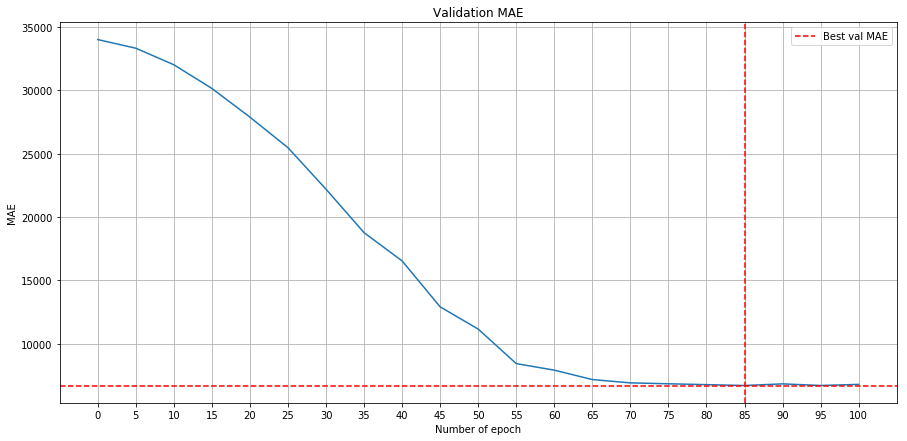

Training:



	Loss:	0.08560
	MAE:	7691.46780



Training:



	Loss:	0.08633
	MAE:	7853.84970



Training:



	Loss:	0.08929
	MAE:	7982.16372



Training:



	Loss:	0.08759
	MAE:	7806.51236



Training:



	Loss:	0.08393
	MAE:	7776.54541



Validation:



	Loss:	0.06394
	MAE:	6530.36708





In [101]:
for epoch_i in range(num_epochs):
    #print("### Epoch:", epoch_i)
    print("Training:")
    train_loss = train_mae = train_batches = 0    
    model.train(True)
    
    for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch):
        title_ix = torch.tensor(batch["Title"], dtype=torch.int64)
        desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64)
        cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32)
        reference = torch.tensor(batch[target_column], dtype=torch.float32)

        prediction = model(title_ix.to(device), desc_ix.to(device), cat_features.to(device))

        loss = compute_loss(reference.to(device), prediction)
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss += loss.data.cpu().numpy()
        train_mae += compute_mae(reference.to(device), prediction).data.cpu().numpy()
        train_batches += 1
    
    #scheduler.step(train_mae / train_batches)
    print("\tLoss:\t%.5f" % (train_loss / train_batches))
    print("\tMAE:\t%.5f" % (train_mae / train_batches))
    print('\n\n')
    
    if (epoch_i % 5):
        continue
        
    print("Validation:")
    val_loss = val_mae = val_batches = 0
    model.train(False)
    
    for batch in iterate_minibatches(data_val, shuffle=False):
        title_ix = torch.tensor(batch["Title"], dtype=torch.int64)
        desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64)
        cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32)
        reference = torch.tensor(batch[target_column], dtype=torch.float32)
        prediction = model(title_ix.to(device), desc_ix.to(device), cat_features.to(device))
        loss = compute_loss(reference.to(device), prediction)

        val_loss += loss.data.cpu().numpy()
        val_mae += compute_mae(reference.to(device), prediction).data.cpu().numpy()
        val_batches += 1
        
    print("\tLoss:\t%.5f" % (val_loss / val_batches))
    print("\tMAE:\t%.5f" % (val_mae / val_batches))
    print('\n\n')
    if (stopper.step(epoch_i, model, (val_mae / val_batches))):
        continue
    else:
        model.load_state_dict(stopper.model_state)
        break

In [102]:
print("Final eval:")
val_loss = val_mae = val_batches = 0
model.train(False)

for batch in iterate_minibatches(data_val, shuffle=False):
    title_ix = torch.tensor(batch["Title"], dtype=torch.int64)
    desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64)
    cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32)
    reference = torch.tensor(batch[target_column], dtype=torch.float32)

    prediction = model(title_ix.to(device), desc_ix.to(device), cat_features.to(device))
    loss = compute_loss(reference.to(device), prediction)

    val_loss += loss.data.cpu().numpy()
    val_mae += compute_mae(reference.to(device), prediction).data.cpu().numpy()
    val_batches += 1

print("\tLoss:\t%.5f" % (val_loss / val_batches))
print("\tMAE:\t%.5f" % (val_mae / val_batches))
print('\n\n')

Final eval:



	Loss:	0.06394
	MAE:	6530.36708





## ========================= Fourth approach ================================

Apparently, training MAE is still a way higher than validation MAE so probably the network is still trainable.
In this approach, let's try to increase number of epochs and batches per epoch

In [103]:
model = FullNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
stopper = EarlyStopper(patience=7)

In [104]:
num_epochs = 250
max_len = 100
batch_size = 32
batches_per_epoch = 400

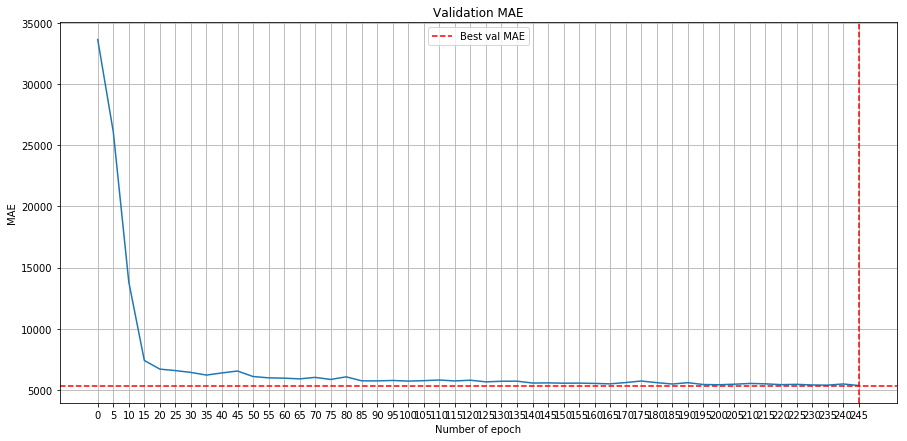

Training:



	Loss:	0.04070
	MAE:	5497.87480



Training:



	Loss:	0.03868
	MAE:	5383.64411



Training:



	Loss:	0.04043
	MAE:	5492.49470



Training:



	Loss:	0.03999
	MAE:	5388.87354





In [105]:
for epoch_i in range(num_epochs):
    #print("### Epoch:", epoch_i)
    print("Training:")
    train_loss = train_mae = train_batches = 0    
    model.train(True)
    
    for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch):
        title_ix = torch.tensor(batch["Title"], dtype=torch.int64)
        desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64)
        cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32)
        reference = torch.tensor(batch[target_column], dtype=torch.float32)

        prediction = model(title_ix.to(device), desc_ix.to(device), cat_features.to(device))

        loss = compute_loss(reference.to(device), prediction)
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss += loss.data.cpu().numpy()
        train_mae += compute_mae(reference.to(device), prediction).data.cpu().numpy()
        train_batches += 1
    
    #scheduler.step(train_mae / train_batches)
    print("\tLoss:\t%.5f" % (train_loss / train_batches))
    print("\tMAE:\t%.5f" % (train_mae / train_batches))
    print('\n\n')
    
    if (epoch_i % 5):
        continue
        
    print("Validation:")
    val_loss = val_mae = val_batches = 0
    model.train(False)
    
    for batch in iterate_minibatches(data_val, shuffle=False):
        title_ix = torch.tensor(batch["Title"], dtype=torch.int64)
        desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64)
        cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32)
        reference = torch.tensor(batch[target_column], dtype=torch.float32)
        prediction = model(title_ix.to(device), desc_ix.to(device), cat_features.to(device))
        loss = compute_loss(reference.to(device), prediction)

        val_loss += loss.data.cpu().numpy()
        val_mae += compute_mae(reference.to(device), prediction).data.cpu().numpy()
        val_batches += 1
        
    print("\tLoss:\t%.5f" % (val_loss / val_batches))
    print("\tMAE:\t%.5f" % (val_mae / val_batches))
    print('\n\n')
    if (stopper.step(epoch_i, model, (val_mae / val_batches))):
        continue
    else:
        model.load_state_dict(stopper.model_state)
        break

In [107]:
print("Final eval:")
val_loss = val_mae = val_batches = 0
model.train(False)

for batch in iterate_minibatches(data_val, shuffle=False):
    title_ix = torch.tensor(batch["Title"], dtype=torch.int64)
    desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64)
    cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32)
    reference = torch.tensor(batch[target_column], dtype=torch.float32)

    prediction = model(title_ix.to(device), desc_ix.to(device), cat_features.to(device))
    loss = compute_loss(reference.to(device), prediction)

    val_loss += loss.data.cpu().numpy()
    val_mae += compute_mae(reference.to(device), prediction).data.cpu().numpy()
    val_batches += 1

print("\tLoss:\t%.5f" % (val_loss / val_batches))
print("\tMAE:\t%.5f" % (val_mae / val_batches))
print('\n\n')

Final eval:



	Loss:	0.04799
	MAE:	5372.79982





## ========================= Fifth approach ==============================

#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
  * Please bear in mind that while convolution uses [batch, units, time] dim order, 
    recurrent units are built for [batch, time, unit]. You may need to `torch.transpose`.

* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left 
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description

In [28]:
from IPython import display

class EarlyStopper():
    def __init__(self, patience=10):
        self.patience = patience
        self.last_score = 1e+6
        self.last_epoch = 0
        self.steps = 0
        self.eps = 1e-3
        self.model_state = None
        self.score_hist = []
        self.epoch_hist = []
        self.train_hist = []
    def step(self, epoch, model, train_score, score):
        if (self.steps >= self.patience):
            return False
        if (self.eps < (self.last_score - score)):
            self.last_score = score
            self.last_epoch = epoch
            self.model_state = model.state_dict()
            self.steps = 0
        else:
            self.steps = self.steps + 1
        self.plot(epoch, train_score, score)
        return True
    def plot(self, epoch, train_score, score):
        display.clear_output(wait=True)
        self.epoch_hist.append(epoch)
        self.score_hist.append(score)
        self.train_hist.append(train_score)
        if (len(self.epoch_hist) < 3):
            return
        plt.figure(figsize=(15, 7))  
        plt.title("Early stop", size=16)
        plt.xlabel("Number of epoch", size=16)
        plt.ylabel("MAE", size=16)
        plt.plot(self.epoch_hist, self.train_hist, c='b', label="Training MAE")
        plt.plot(self.epoch_hist, self.score_hist, c='r', label="Validation MAE")
        plt.axvline(self.last_epoch, ls='dashed', c='r', label='Best valid MAE')
        plt.axhline(self.last_score, ls='dashed', c='r')
        plt.xticks(self.epoch_hist[::2])
        plt.legend()
        plt.grid()
        plt.show()

In [33]:
class AttentivePooling(nn.Module):
    def __init__(self, channel):
        super(self.__class__, self).__init__()
        self.conv1 = nn.Conv1d(channel, channel, kernel_size=3, padding=1)
        #self.activ1 = nn.ReLU()
        #self.conv2 = nn.Conv1d(channel, channel, kernel_size=3, padding=1)
        self.activ2 = nn.Softmax(dim=2)
    def forward(self, vector):
        out = self.activ2(self.conv1(vector))
        #out = self.activ2(self.conv2(out))
        out = (out * vector).sum(dim=2)
        return out
    
class SoftmaxPooling(nn.Module):
    def __init__(self):
        super(self.__class__, self).__init__()
        self.activ = nn.Softmax(dim=2)
    def forward(self, vector):
        return (vector * self.activ(vector)).sum(dim=2)

class TitleEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.lstm = nn.LSTM(64, out_size, batch_first=True, bidirectional=True)
        self.pool1 = GlobalMaxPooling()
        self.dense = nn.Linear(2*out_size, out_size)
        self.bn = nn.BatchNorm1d(out_size)
        self.activ = nn.ReLU()

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)
        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h, _ = self.lstm(h)
        h = self.pool1(torch.transpose(h, 1, 2))
        h = self.bn(self.dense(h))
        
        return self.activ(h)
    
class DescriptionEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for descriptions.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.lstm = nn.LSTM(64, out_size, batch_first=True, bidirectional=True)
        self.pool1 = GlobalMaxPooling()
        self.dense = nn.Linear(2*out_size, out_size)
        self.bn = nn.BatchNorm1d(out_size)
        self.activ = nn.ReLU()
        #self.dense2 = nn.Linear(2 * out_size, out_size)
        #self.bn2 = nn.BatchNorm1d(out_size)
        #self.activ2 = nn.ReLU()

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)
        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h, _ = self.lstm(h)
        h = self.pool1(torch.transpose(h, 1, 2))
        h = self.bn(self.dense(h))
        
        return self.activ(h)
    
class FullNetwork(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """
    
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()
        
        self.title_encoder = TitleEncoder(out_size=32)
        self.desc_encoder = DescriptionEncoder(out_size=32)
        
        # define layers for categorical features. A few dense layers would do.
        self.cat_encoder = nn.Sequential(
            nn.Linear(n_cat_features, 2000),
            nn.ReLU(),
            nn.Linear(2000, 1000),
            nn.ReLU(),
            nn.Linear(1000, 100),
            nn.BatchNorm1d(100),
            nn.ReLU()
        )
        
        # define "output" layers that process depend the three encoded vectors into answer
        self.sink = nn.Sequential(
            nn.Linear(100 + 32 + 32, 100),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(100, 1)
        )        
        
    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """
        
        # process each data source with it's respective encoder
        title_h = self.title_encoder(title_ix)
        desc_h = self.desc_encoder(desc_ix)
        
        # apply categorical encoder
        cat_h = self.cat_encoder(cat_features)
        
        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        
        # ... and stack a few more layers at the top
        salary = torch.log1p(self.sink(joint_h))
        
        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.
        
        return salary[:, 0]

In [34]:
model = FullNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
stopper = EarlyStopper(patience=7)

In [35]:
num_epochs = 250
max_len = 100
batch_size = 32
batches_per_epoch = 100

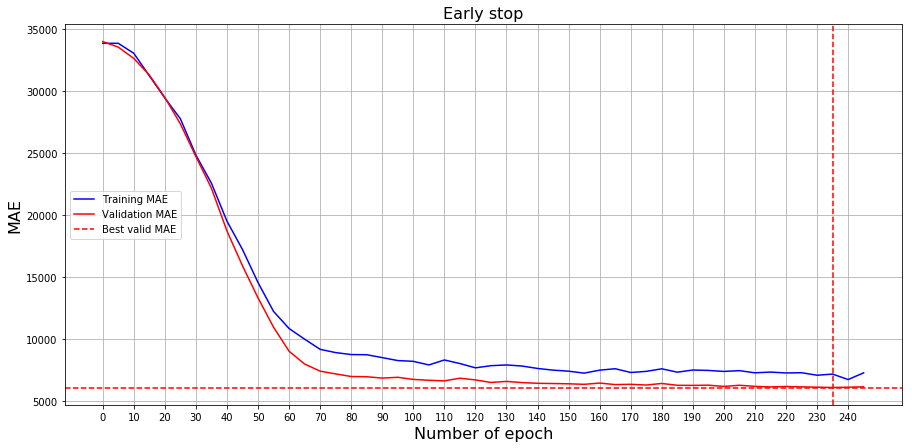

Training:



	Loss:	0.07204
	MAE:	7234.38413



Training:



	Loss:	0.07091
	MAE:	7063.89715



Training:



	Loss:	0.07356
	MAE:	7192.02300



Training:



	Loss:	0.07254
	MAE:	7084.62723





In [36]:
for epoch_i in range(num_epochs):
    #print("### Epoch:", epoch_i)
    print("Training:")
    train_loss = train_mae = train_batches = 0    
    model.train(True)
    
    for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch):
        title_ix = torch.tensor(batch["Title"], dtype=torch.int64)
        desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64)
        cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32)
        reference = torch.tensor(batch[target_column], dtype=torch.float32)

        prediction = model(title_ix.to(device), desc_ix.to(device), cat_features.to(device))

        loss = compute_loss(reference.to(device), prediction)
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss += loss.data.cpu().numpy()
        train_mae += compute_mae(reference.to(device), prediction).data.cpu().numpy()
        train_batches += 1
    
    #scheduler.step(train_mae / train_batches)
    print("\tLoss:\t%.5f" % (train_loss / train_batches))
    print("\tMAE:\t%.5f" % (train_mae / train_batches))
    print('\n\n')
    
    if (epoch_i % 5):
        continue
        
    print("Validation:")
    val_loss = val_mae = val_batches = 0
    model.train(False)
    
    for batch in iterate_minibatches(data_val, shuffle=False):
        title_ix = torch.tensor(batch["Title"], dtype=torch.int64)
        desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64)
        cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32)
        reference = torch.tensor(batch[target_column], dtype=torch.float32)
        prediction = model(title_ix.to(device), desc_ix.to(device), cat_features.to(device))
        loss = compute_loss(reference.to(device), prediction)

        val_loss += loss.data.cpu().numpy()
        val_mae += compute_mae(reference.to(device), prediction).data.cpu().numpy()
        val_batches += 1
        
    print("\tLoss:\t%.5f" % (val_loss / val_batches))
    print("\tMAE:\t%.5f" % (val_mae / val_batches))
    print('\n\n')
    if (stopper.step(epoch_i, model, (train_mae / train_batches), (val_mae / val_batches))):
        continue
    else:
        print("Early stop!")
        model.load_state_dict(stopper.model_state)
        break

In [37]:
print("Final eval:")
val_loss = val_mae = val_batches = 0
model.train(False)

for batch in iterate_minibatches(data_val, shuffle=False):
    title_ix = torch.tensor(batch["Title"], dtype=torch.int64)
    desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64)
    cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32)
    reference = torch.tensor(batch[target_column], dtype=torch.float32)

    prediction = model(title_ix.to(device), desc_ix.to(device), cat_features.to(device))
    loss = compute_loss(reference.to(device), prediction)

    val_loss += loss.data.cpu().numpy()
    val_mae += compute_mae(reference.to(device), prediction).data.cpu().numpy()
    val_batches += 1

print("\tLoss:\t%.5f" % (val_loss / val_batches))
print("\tMAE:\t%.5f" % (val_mae / val_batches))
print('\n\n')

Final eval:



	Loss:	0.05852
	MAE:	6118.67175





### A short report

So, let's finalize results we obtained:

As the first step I used very basic network and obtained **7523 MAE** which I considered to be a **baseline**. As the next step I decided to follow the guidline given and added parallel convolutional layers with different strides (as well as batch norm and DropOut to the final layer). This gave **6744 MAE** which is better in 800 MAE.

Then I decided to improve it further on and added Attentive Pooling layer alongside with SoftMax pooling and GlobalMaxPooling, the idea of attentive pooling is to train weights accordingly to its importance and propagate weigths for all of input neurons. This helped to obtain a better result: **6654 MAE**.

While training I observed that the MAE score as well as loss is getting a bit unstable closer the end of training procedure. Due to this fact I implemented Early Stopper class which is constantly monitoring parameters. This helped to get **6530  MAE** which is slightly better. 

To ensure that this sequence of results can be reproducible I ran all setup second time and observed the same behaviour.

Finally, I noticed that the validation score is still lower than the training score and decided to train it further. After 250 epochs the network managed to reach **5372 MAE** on validation (also the number of batches per epoch was also increased). But closer to the finish early stopper was constantly reporting that the training procedure is not stable, so I also adjusted patience level from 3 to 7.

Apart from that, I tried to use bidirectional LSTM unit and check results, so this network gave **6118 MAE** after 250 epochs with 100 BPE. 